In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import requests
import json
import pandas as pd
from pandas import json_normalize
import time
from itertools import cycle,zip_longest
import csv
import numpy as np

In [ ]:
#api_key 매일 갱신 필요

api_key0 = "RGAPI-5db8a3b5-9841-4858-9627-34865b9e912a" #뿌구리
api_key1=  "RGAPI-8dcf6ced-2284-497f-8f32-9976209bf37a" #쁘댕이
api_key2=  "RGAPI-fb86269e-a7e9-4691-b508-9dd3ec7e5291" #겸도리
api_keys=[api_key0,api_key1,api_key2]
game_Name = "뿌구리"
tag_Line= "KR1"
region = "ASIA"

#닉네임+태그네임으로 puuid 호출
url=f"https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_Name}/{tag_Line}?api_key={api_key0}"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
}
my_puuid = json.loads(requests.get(url, headers=headers).text)['puuid']
my_puuid

'T1DSg3IAIRSBB5EaQsC5Bnb-DxY1iwSns_mzp0YZQr69PbHrAtq66tIjWq0deh7p5Xji8WdGUYPGnA'

In [ ]:
# 이름+태그번호로 puuid 받아오기
def get_puuid(api_key0, game_Name, tag_Line, region):
    url = f"https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_Name}/{tag_Line}?api_key={api_key0}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
        "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
        "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
        "Origin": "https://developer.riotgames.com"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # 요청이 성공적이지 않으면 예외 발생
        data = response.json()
        my_puuid = data['puuid']
        return my_puuid
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

In [ ]:
#챌린저 데이터

url=f"https://kr.api.riotgames.com/tft/league/v1/challenger?queue=RANKED_TFT&api_key={api_key0}"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
}

#df에는 entries를 제외하고 유용한 데이터 없음 전부 같은 데이터
df=pd.DataFrame(json.loads(requests.get(url, headers=headers).text))

#entries 에 있는 데이터 중첩 풀어서 df로 변환
challenger_df = json_normalize(df['entries'])


In [ ]:
#챌린저 암호화된 소환사id->puuid
challenger_puuid=[]
count=1
for i in range(challenger_df.shape[0]):
  url=f"https://kr.api.riotgames.com/tft/summoner/v1/summoners/{challenger_df.iloc[i,0]}?api_key={api_key0}"
  headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
          }
  p=json.loads(requests.get(url, headers=headers).text)['puuid']
  challenger_puuid.append(p)
  time.sleep(0.05)
  count+=1
  if count%100==0:
    time.sleep(116)

In [ ]:
#챌린저 puuid 리스트 저장
with open('challenger_puuid.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(challenger_puuid)

In [ ]:
#챌린저 puuid 불러오기
challenger_puuid = list(pd.read_csv('/content/drive/MyDrive/challenger_puuid.csv'))

In [ ]:
#puuid를 통해서 최근 20경기 매치를 뽑아낸다
count=1
challenger_matchid=[]
for i in challenger_puuid:
  url=f"https://asia.api.riotgames.com/tft/match/v1/matches/by-puuid/{i}/ids?start=0&count=20&api_key={api_key0}"
  headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
          }
  match_id=json.loads(requests.get(url, headers=headers).text)
  challenger_matchid.extend(match_id)
  time.sleep(0.05)
  count+=1
  if count%100==0:
    time.sleep(115)
challenger_matchid=list(set(challenger_matchid))

In [ ]:
#챌린저 match_id 리스트 저장

with open('challenger_matchid.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(challenger_matchid)

NameError: name 'challenger_matchid' is not defined

In [ ]:
#challenger_matchid 불러오기 + 1259번째 이상값 제거
challenger_matchid=list(pd.read_csv('/content/drive/MyDrive/challenger_matchid.csv'))
challenger_matchid.remove('status')

In [ ]:
#챌린저 경기 결과 데이터 가져오기
challenger_game_Data=pd.DataFrame()
count=1
error_count=0
for i,j in zip(challenger_matchid,cycle(api_keys)):
  try:
    url=f"https://asia.api.riotgames.com/tft/match/v1/matches/{i}?api_key={j}"
    x=json.loads(requests.get(url, headers=headers).text)['info']
    game_datetime=x['game_datetime']
    game_version=x['game_version']
    y=pd.DataFrame(x['participants'])
    y.drop(columns=['gold_left','last_round','level','missions','companion','puuid','players_eliminated','time_eliminated','total_damage_to_players'],inplace=True)
    y['game_datetime']=game_datetime
    y['game_version']=game_version
    challenger_game_Data=pd.concat([challenger_game_Data,y])
    time.sleep(0.05)
  except:
    error_count+=1
    continue
  count+=1
  if count%300==0:
    time.sleep(115)

#저장
challenger_game_Data=challenger_game_Data.reset_index(drop=True)
challenger_game_Data.to_feather('/content/drive/MyDrive/challenger_game_Data.feather')



In [ ]:
error_count

11

In [8]:
#챌린저 게임 불러오기
df = pd.read_feather('/content/drive/MyDrive/challenger_game_Data.feather')

In [5]:
#주요 특성 뽑기
main_traits=[]
sub=[]
for i in range(len(df['traits'])):
  sub=[]
  for j in range(len(df['traits'][i])):
    traits=df['traits'][i][j]
    if traits['name'] not in ['TFT11_Lovers','TFT11_Great','TFT11_Artist','TFT11_SpiritWalker'] and traits['style']>=2:
      sub.append(traits['name'])
  main_traits.append(sub)

#주요특성 df에 반영
df['main_traits']=main_traits

In [6]:
#특성별 평균,분산
traits_stat = []

for i in range(len(df['main_traits'])):
    for j in range(len(df['main_traits'][i])):
        traits_stat.append({'trait': df['main_traits'][i][j], 'placement': df['placement'][i]})
traits_stat=pd.DataFrame(traits_stat).groupby('trait').agg({'placement': ['mean', 'var']}).sort_values(by=('placement','mean'))
traits_stat

placement          
                       mean       var
trait                                
TFT11_Altruist     3.824728  4.446789
TFT11_Exalted      3.937188  5.147071
TFT11_Ghostly      3.986143  5.334168
TFT11_Dryad        4.049327  5.903324
TFT11_Porcelain    4.173668  5.353926
TFT11_Invoker      4.176024  5.219158
TFT11_Dragonlord   4.187699  5.088165
TFT11_InkShadow    4.211429  4.684926
TFT11_Behemoth     4.264095  5.290165
TFT11_Heavenly     4.283531  4.975629
TFT11_Sage         4.284101  4.531541
TFT11_Arcanist     4.308824  5.083933
TFT11_Trickshot    4.392803  5.052253
TFT11_Umbral       4.435653  4.782354
TFT11_Fated        4.436845  4.946533
TFT11_Duelist      4.440741  5.062615
TFT11_Mythic       4.481419  5.336372
TFT11_Bruiser      4.495017  4.997109
TFT11_Storyweaver  4.526415  4.782855
TFT11_Warden       4.608889  5.300811
TFT11_Reaper       4.802083  4.725022
TFT11_Sniper       4.846847  4.694513
TFT11_Fortune      5.754717  8.765602

In [13]:
df_eng_kor_traits

,TFT11_Mythic,TFT11_InkShadow,TFT11_Storyweaver,TFT11_Ghostly,TFT11_Fated,TFT11_Heavenly,TFT11_Dryad,TFT11_Fortune,TFT11_Porcelain,TFT11_Dragonlord,...,TFT11_Warden,TFT11_Altruist,TFT11_Trickshot,TFT11_Great,TFT11_Sage,TFT11_Exalted,TFT11_Artist,TFT11_Lovers,TFT11_Sniper,TFT11_TrickshotAltruist
id,TFT11_Mythic,TFT11_InkShadow,TFT11_Storyweaver,TFT11_Ghostly,TFT11_Fated,TFT11_Heavenly,TFT11_Dryad,TFT11_Fortune,TFT11_Porcelain,TFT11_Dragonlord,...,TFT11_Warden,TFT11_Altruist,TFT11_Trickshot,TFT11_Great,TFT11_Sage,TFT11_Exalted,TFT11_Artist,TFT11_Lovers,TFT11_Sniper,TFT11_TrickshotAltruist
name,신화,먹그림자,이야기꾼,혼령,필연,천계,숲지기,행운,도자기,용군주,...,파수꾼,이타심,재주꾼,호걸,현자,귀인,예술가,연인,저격수,재주꾼/이타심


In [14]:
# 아랫놈 최적화 나중에 해보자!!!
df_champ_usage=pd.DataFrame(np.zeros((df.shape[0],df_eng_kor_champion.shape[1])),columns=df_eng_kor_champion.columns)

In [9]:
# 챔프 사용 여부 df 만들기

df_champ_usage=pd.DataFrame(columns=df_eng_kor_champion.columns)

for i in range(len(df['units'])):
  units=[]
  for j in range(len(df['units'][i])):
    units.append(df['units'][i][j]['character_id'])
  ithchamplist=[]
  for k in range(len(df_champ_usage.columns)):
    if df_champ_usage.columns[k] in units:
      ithchamplist.append(1)
    else:
      ithchamplist.append(0)
  df_champ_usage.loc[i]=ithchamplist

df_champ_usage

,TFT11_Aatrox,TFT11_Ahri,TFT11_Amumu,TFT11_Annie,TFT11_Aphelios,TFT11_Ashe,TFT11_Alune,TFT11_Bard,TFT11_Caitlyn,TFT11_ChoGath,...,TFT11_FortuneYord,TFT11_RekSai,TFT11_Xayah,TFT11_Gnar,TFT11_Rakan,TFT11_Jax,TFT11_Diana,TFT11_Azir,TFT11_Nautilus,TFT11_XayahRakanDummy
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21876,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
21877,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [10]:
df_champ_usage.sum().sort_values(ascending=False)

TFT11_Ornn               6998
TFT11_Lissandra          6784
TFT11_Riven              6069
TFT11_Galio              6060
TFT11_Sylas              5907
                         ... 
TFT11_ChoGath             582
TFT11_Garen               490
TFT11_Jax                 477
TFT11_FortuneYord         331
TFT11_XayahRakanDummy       0
Length: 61, dtype: int64

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

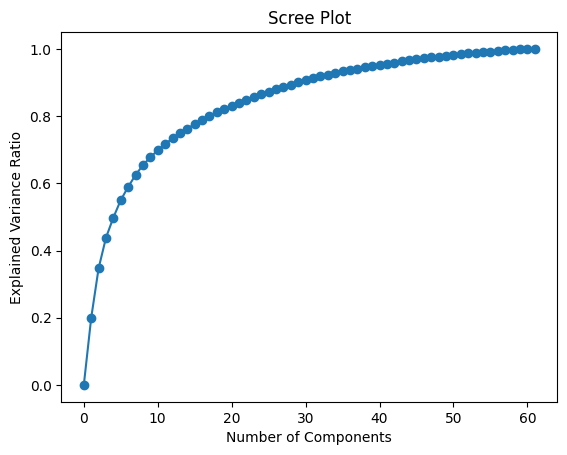

In [12]:
n_components = range(len(df_champ_usage.columns)+1)
explained_variance_ratio = []

# PCA 모델 생성 및 주성분 분석 수행
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(df_champ_usage)
    explained_variance_ratio.append(np.sum(pca.explained_variance_ratio_))

# Scree plot 그리기
plt.plot(n_components, explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()


In [ ]:
#0.7 / 0.8 /0.9 구간에서 요소가 몇개 남는지 확인
for i in n_components:
  if explained_variance_ratio[i]>=0.8:
    print(i)
    break

17


In [13]:
pca = PCA(n_components=17)
pca.fit(df_champ_usage)

PCA(n_components=17)

In [14]:
pca_champ_usage=pca.transform(df_champ_usage)

In [15]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_champ_usage)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 31), wcss)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=0)
pca_champ_kmean = kmeans.fit(pca_champ_usage)

In [31]:
p_champ_usage=df_champ_usage
p_champ_usage['class']=pca_champ_kmean.labels_
p_class15=p_champ_usage.groupby('class').sum()

,TFT11_Aatrox,TFT11_Ahri,TFT11_Amumu,TFT11_Annie,TFT11_Aphelios,TFT11_Ashe,TFT11_Alune,TFT11_Bard,TFT11_Caitlyn,TFT11_ChoGath,...,TFT11_FortuneYord,TFT11_RekSai,TFT11_Xayah,TFT11_Gnar,TFT11_Rakan,TFT11_Jax,TFT11_Diana,TFT11_Azir,TFT11_Nautilus,TFT11_XayahRakanDummy
class,,,,,,,,,,,,,,,,,,,,,
0,0,10,11,12,1,2,6,5,0,13,...,1,3,7,0,665,1,1110,22,9,0
1,1,1,1098,1108,75,1180,89,16,14,35,...,0,3,5,14,4,7,9,815,1088,0
2,3338,0,3,79,1,6,3,885,2,6,...,81,53,2633,5,19,76,44,27,22,0
3,2,1460,191,68,1305,388,21,2,18,6,...,1,18,0,70,9,8,7,116,177,0
4,446,0,13,59,2,5,46,3,3,3,...,36,33,9,1,459,1,897,36,12,0
5,1107,6,27,15,7,4,5,2,56,1,...,3,1008,0,1317,7,22,8,530,29,0
6,1,1,5,2,2,0,11,1,0,0,...,0,0,5,3,184,1,601,6,4,0
7,90,1,9,124,0,6,5,25,2,3,...,5,2,539,6,6,47,511,327,16,0
8,470,11,90,217,20,146,70,22,264,96,...,89,74,110,37,27,230,88,114,224,0


In [40]:
p_class15.iloc[2,:].sort_values(ascending=False)

TFT11_Galio              3503
TFT11_Kaisa              3499
TFT11_Riven              3466
TFT11_Sivir              3382
TFT11_Aatrox             3338
TFT11_Teemo              3335
TFT11_Sylas              3322
TFT11_Xayah              2633
TFT11_Udyr               1965
TFT11_Bard                885
TFT11_TahmKench           235
TFT11_Lissandra           234
TFT11_Ornn                223
TFT11_Volibear            209
TFT11_Senna                89
TFT11_LeeSin               83
TFT11_FortuneYord          81
TFT11_Janna                80
TFT11_Annie                79
TFT11_Jax                  76
TFT11_Irelia               74
TFT11_Shen                 60
TFT11_Soraka               54
TFT11_RekSai               53
TFT11_Diana                44
TFT11_Hwei                 42
TFT11_Sett                 35
TFT11_Azir                 27
TFT11_Garen                25
TFT11_Yorick               23
TFT11_Nautilus             22
TFT11_Zoe                  22
TFT11_Zyra                 20
TFT11_Raka

In [19]:
df['class']=pca_champ_kmean.labels_

pca_kmean_traits_stat=pd.DataFrame(df).groupby('class').agg({'placement': ['mean', 'var']}).sort_values(by=('placement','mean'))

placement          
           mean       var
class                    
13     4.200000  5.814542
5      4.260870  6.053426
0      4.343319  4.929799
7      4.363036  5.699392
3      4.451327  4.951140
2      4.503363  5.152778
9      4.503766  4.755405
11     4.512802  5.576045
1      4.524038  5.446094
6      4.534075  5.148907
10     4.563507  4.929996
4      4.693857  4.234811
8      4.748634  5.364287
12     4.824295  5.217737
14     4.860530  5.251471

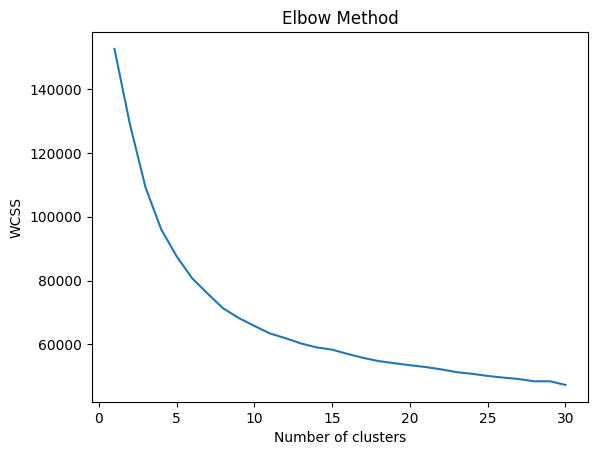

In [18]:
from sklearn.cluster import KMeans

# Elbow Method를 이용하여 적절한 클러스터 수 찾기
wcss = []
for i in range(1,31 ):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_champ_usage)
    wcss.append(kmeans.inertia_)

# Elbow Point 찾기
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

In [19]:
# 선택한 클러스터 수로 KMeans 적용
k = int(input("Enter the number of clusters based on the Elbow Method: "))
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
champ_kmean = kmeans.fit(df_champ_usage)


Enter the number of clusters based on the Elbow Method: 15


In [20]:
#kmean 결과 챔프 리스트에 추가
df_champ_usage['class']=champ_kmean.labels_

In [21]:
class15=df_champ_usage.groupby('class').sum()
class15

,TFT11_Aatrox,TFT11_Ahri,TFT11_Amumu,TFT11_Annie,TFT11_Aphelios,TFT11_Ashe,TFT11_Alune,TFT11_Bard,TFT11_Caitlyn,TFT11_ChoGath,...,TFT11_FortuneYord,TFT11_RekSai,TFT11_Xayah,TFT11_Gnar,TFT11_Rakan,TFT11_Jax,TFT11_Diana,TFT11_Azir,TFT11_Nautilus,TFT11_XayahRakanDummy
class,,,,,,,,,,,,,,,,,,,,,
0,22,365,878,125,448,619,31,6,57,3,...,3,8,10,68,18,61,30,75,542,0
1,7,5,3766,3760,128,3832,384,20,38,65,...,7,13,8,43,28,23,29,2507,3717,0
2,1903,0,1,35,0,3,0,279,0,4,...,29,10,1634,3,11,14,17,18,5,0
3,29,10,61,601,12,132,223,334,199,358,...,46,23,31,10,69,18,45,325,805,0
4,2,10,12,11,1,2,6,4,0,10,...,1,3,7,1,662,1,1108,22,9,0
5,1354,7,49,24,11,34,6,2,275,2,...,4,1023,12,1335,11,138,14,550,50,0
6,16,2,17,131,1,7,38,8,4,2,...,11,6,32,12,628,0,967,113,14,0
7,50,6,21,292,4,11,1096,6,5,118,...,10,19,4,12,17,8,42,444,110,0
8,1518,1,3,46,1,8,12,609,8,2,...,116,93,1010,4,9,71,38,20,24,0


In [21]:
# 아래 결과 다보고 싶으면 실행
pd.set_option('display.max_rows', None)

In [30]:
class15.iloc[2,:].sort_values(ascending=False) #개쩐다 이게 왜 됌?ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

TFT11_Udyr               1973
TFT11_Kaisa              1954
TFT11_Galio              1924
TFT11_Aatrox             1903
TFT11_Riven              1893
TFT11_Sivir              1873
TFT11_Teemo              1851
TFT11_Sylas              1832
TFT11_Xayah              1634
TFT11_Bard                279
TFT11_Ornn                178
TFT11_Lissandra           135
TFT11_TahmKench            68
TFT11_Shen                 44
TFT11_Irelia               40
TFT11_Janna                38
TFT11_LeeSin               35
TFT11_Annie                35
TFT11_Volibear             31
TFT11_Soraka               30
TFT11_FortuneYord          29
TFT11_Hwei                 20
TFT11_Sett                 19
TFT11_Azir                 18
TFT11_Diana                17
TFT11_Yorick               16
TFT11_Jax                  14
TFT11_Senna                12
TFT11_Rakan                11
TFT11_RekSai               10
TFT11_Zoe                   9
TFT11_Zyra                  8
TFT11_Thresh                7
TFT11_Morg

In [ ]:
# 다 보고 옵션 초기화 하고싶으면 실행
pd.reset_option('display.max_rows')

In [24]:
df['class']=champ_kmean.labels_

kmean_traits_stat=pd.DataFrame(df).groupby('class').agg({'placement': ['mean', 'var']}).sort_values(by=('placement','mean'))

placement          
           mean       var
class                    
2      3.616827  4.251684
14     4.217882  5.883850
5      4.333955  5.876581
10     4.336606  5.484852
4      4.344637  4.939166
12     4.461878  4.952360
6      4.500501  4.947645
1      4.509944  5.529740
7      4.526059  4.885221
9      4.557103  5.184322
13     4.683179  4.247661
11     4.686475  4.995956
0      4.821179  5.230991
3      4.824031  5.257607
8      5.552476  4.234413

In [ ]:
pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력

In [ ]:
pd.set_option('display.max_rows', 15)  # 15 행 출력
pd.set_option('display.max_columns', 15)  # 15 열 출력

In [ ]:
i=challenger_matchid[1]
j=api_keys[1]
url=f"https://asia.api.riotgames.com/tft/match/v1/matches/{i}?api_key={j}"
x=json.loads(requests.get(url, headers=headers).text)['info']
y=pd.DataFrame(x['participants'])

In [ ]:
challenger_game_Data=pd.DataFrame()

In [ ]:
i=challenger_matchid[1]
j=api_keys[1]
url=f"https://asia.api.riotgames.com/tft/match/v1/matches/{i}?api_key={j}"
x=pd.DataFrame(json.loads(requests.get(url, headers=headers).text)['info'])
game_datetime=x.loc[0,'game_datetime']
game_version=x.loc[0,'game_version']
y=pd.DataFrame(json.loads(requests.get(url, headers=headers).text)['info']['participants'])
z=y.drop(columns=['gold_left','last_round','level','missions','companion','puuid','players_eliminated','time_eliminated','total_damage_to_players'])
z['game_datetime']=game_datetime
z['game_version']=game_version


In [ ]:
challenger_game_Data=pd.concat([challenger_game_Data,z])
challenger_game_Data

In [ ]:
y

In [ ]:
#각 경기 참가자의 특성/유닛을 뽑아 보자
participants=pd.DataFrame(game_Data['info']['participants'])

#첫번째 유저 특성.유닛 <<<<<<<<<<,한명의 유저의 특성만 확인한거임!!!!!!!!!!!!!!!!
user_traits=pd.DataFrame(participants.loc[0,'traits'])
user_units=pd.DataFrame(participants.loc[0,'units'])

In [ ]:
len(participants.loc[0,'traits'])

13

In [7]:
#data dragon에서 한글 파일을 가져와서 파일을 한글로 바꿔보자
with open('/content/drive/MyDrive/tft-trait.json','r') as json_file:
  data_dragon_trait=json.load(json_file)

with open('/content/drive/MyDrive/tft-champion.json','r') as json_file:
  data_dragon_champion=json.load(json_file)

with open('/content/drive/MyDrive/tft-item.json','r') as json_file:
  data_dragon_item=json.load(json_file)

with open('/content/drive/MyDrive/tft-augments.json','r') as json_file:
  data_dragon_augments=json.load(json_file)


#traits-특성 dic 만들기
df=pd.DataFrame(data_dragon_trait['data'])
df_eng_kor_traits=df.filter(like='TFT11', axis=1).iloc[0:2,:]
dic_eng_kor_traits={df_eng_kor_traits.iloc[0,i] : df_eng_kor_traits.iloc[1,i] for i in range (df_eng_kor_traits.shape[1]) }
#champion-영웅 dic 만들기
df=pd.DataFrame(data_dragon_champion['data'])
df_eng_kor_champion=df.filter(like='TFT11', axis=1).iloc[0:2,:]
dic_eng_kor_champion={df_eng_kor_champion.iloc[0,i] : df_eng_kor_champion.iloc[1,i] for i in range (df_eng_kor_champion.shape[1]) }
#item-아이템 dic 만들기 <<<<<<<<<<<아직 사용 안했음
df=pd.DataFrame(data_dragon_item['data'])
df_eng_kor_item=df.iloc[0:2,:]
dic_eng_kor_item={df_eng_kor_item.iloc[0,i] : df_eng_kor_item.iloc[1,i] for i in range (df_eng_kor_item.shape[1]) }
#augments-특성 dic 만들기
df=pd.DataFrame(data_dragon_augments['data'])
df_eng_kor_augments=df.iloc[0:2,:]
dic_eng_kor_augments={df_eng_kor_augments.iloc[0,i] : df_eng_kor_augments.iloc[1,i] for i in range (df_eng_kor_augments.shape[1]) }

In [ ]:
def kor_units(user_units):
  for i in range (user_units.shape[0]):
    user_units.iloc[i,0]=dic_eng_kor_champion[user_units.iloc[i,0]]
def kor_traits(user_traits):
  for i in range (user_traits.shape[0]):

    user_traits.iloc[i,0]=dic_eng_kor_traits[user_traits.iloc[i,0]]

In [ ]:
def kor_participants(participants):
  for i in range()

In [ ]:
kor_traits(user_traits)
kor_units(user_units)

In [ ]:
game_Data

NameError: name 'game_Data' is not defined

In [ ]:
!pip install roman

In [ ]:
#하위티어 데이터
import roman
Gold_puuid=[]

for i in range(4):
  tier='GOLD' #대문자로 쓸것
  division_num=i+1
  division_rom=roman.toRoman(division_num)
  for j in range(10):
    page=str(j+1)
    url=f'https://kr.api.riotgames.com/tft/league/v1/entries/{tier}/{division_rom}?queue=RANKED_TFT&page={page}&api_key={api_key0}'

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
        "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
        "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
        "Origin": "https://developer.riotgames.com"
    }
    Gold_puuid.extend(pd.DataFrame(json.loads(requests.get(url, headers=headers).text))['puuid'].values.tolist())
    time.sleep(0.05)
Gold_puuid=list(set(Gold_puuid))

#저장
with open('/content/drive/MyDrive/gold_puuid.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(Gold_puuid)

In [ ]:
Gold_puuid=list(pd.read_csv('/content/drive/MyDrive/gold_puuid.csv'))

In [ ]:

#puuid를 통해서 최근 20경기 매치를 뽑아낸다
count=1
gold_matchid=[]
for i in Gold_puuid:
  url=f"https://asia.api.riotgames.com/tft/match/v1/matches/by-puuid/{i}/ids?start=0&count=20&api_key={api_key0}"
  headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7,ja;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
          }
  match_id=json.loads(requests.get(url, headers=headers).text)
  gold_matchid.extend(match_id)
  time.sleep(0.05)
  count+=1
  if count%100==0:
    time.sleep(115)
gold_matchid=list(set(gold_matchid))

#저장
with open('/content/drive/MyDrive/gold_matchid.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(gold_matchid)

KeyboardInterrupt: 

In [ ]:
count

NameError: name 'count' is not defined

In [ ]:
with open('/content/drive/MyDrive/gold_matchid.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(gold_matchid)

In [ ]:
len(Gold_puuid)

8020